In [39]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

# PyTorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

# Equivariant library
import e2cnn
from e2cnn import gspaces

# Other dependencies 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import PIL.Image, PIL.ImageDraw
import time

# Notebook dependencies
from IPython.display import clear_output, Image

# Import necessary functions from personal utils file
from utils import load_emoji, imshow, get_living_mask, to_rgba, visualize_batch,\
    plot_loss, create_filename, save_ca_model, load_ca_model, save_loss_log, load_loss_log, simulate_model


# For file reloading (remove before submission)
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import load_emoji, imshow, get_living_mask, to_rgba, visualize_batch,\
    plot_loss, create_filename, save_ca_model, load_ca_model, save_loss_log, load_loss_log, simulate_model

# Get access to GPU
device_id = 2
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:2


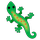

In [9]:
# Model parameters (defaults from original paper)
CHANNEL_N = 16 
HIDDEN_SIZE = 128 # note this it the hidden size for the Dense layer (not equivariant)
CELL_FIRE_RATE = 0.5
BATCH_SIZE = 8

# For "persistent" training
USE_PATTERN_POOL = True
POOL_SIZE = 1024

# Set target
TARGET_EMOJI = "🦎"
TARGET_PADDING = 16
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)


shape of permuted seed: torch.Size([16, 72, 72])


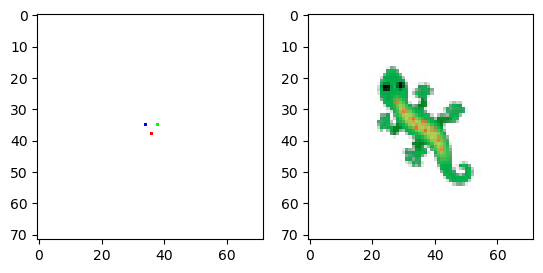

In [10]:
def get_circle_points(a, b, radius, num_points=3):
    """Returns three non-collinear points on a circle, centered
        at (a, b) with radius `radius`.
    
    :param a: int, x coordinate of circle center
    :param b: int, y coordinate of circle center
    :param radius: int, radius of circle 
    :param num_points: int, number of points for asymmetric seed
    """
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = a + radius * math.cos(angle)
        y = b + radius * math.sin(angle)
        points.append((int(round(x)), int(round(y))))
    return points

def make_seed(target_img, radius=None, rot=0, p=TARGET_PADDING, device=device, print_seed=True):
    """Makes an asymmetric seed with three non-collinear points.
        If radius is None, seeds a single pixel.
        `rot` is an int in [1,2,3,4], representing 90 degree
        rotations to the left."""
    target_img = torch.tensor(target_img)
    pad_target = torch.nn.functional.pad(target_img, (0, 0, p, p, p, p))
    h, w = pad_target.shape[:2] # get height and width of padded target image
    x, y = h//2, w//2 # get coordinates of center pixel
    seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
    if radius is None:
        seed[x, y, 3:] = 1.0    
        return seed

    # Rotate the points
    points = get_circle_points(x, y, radius)
    points = [points[(i+rot) % len(points)] for i in range(len(points))]

    # Seed the points
    for color_channel_i, point in enumerate(points):
        seed[point[0], point[1], 3:] = 1.0  # set auxiliary channels
        seed[point[0], point[1], color_channel_i] = 1.0  # set color channel
        
    if print_seed:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        permuted_seed = seed.permute(-1, 0, 1)
        print(f'shape of permuted seed: {permuted_seed.shape}')
        ax1.imshow(seed[..., :4])
        ax2.imshow(pad_target)
        # ax2.imshow(permuted_seed[:4, ...])
        fig.show()
        
    return seed.to(device), pad_target.to(device)

seed, pad_target = make_seed(target_img, radius=2)

In [33]:
# Define model class with equivariant features

class CAModel(nn.Module):
    def __init__(self, 
                 N=4,
                 hidden_repr='trivial', 
                 hidden_repr_size=48, 
                 channel_n=CHANNEL_N, 
                 hidden_size=HIDDEN_SIZE):
        """Defines the model class for our CA.

        :param N: int, number of rotations to define for our group C_N
        :param hidden_repr: str, representation to use in the hidden layer
        :param hidden_repr_size: int, number of feature fields to use in our hidden layer
        :param channel_n: int, number of channels for our target (default to 16)
        :param hidden_size: int, hidden size of our dense layer (after equivariant component)
        """
        super().__init__()
        self.hidden_repr_size = hidden_repr_size
        self.channel_n = channel_n

        ## Construct learnable, equivariant perception layer

        # First we define the action on our input space (in this case rotation on C_N)
        r2_act = gspaces.Rot2dOnR2(N)

        # Define the transformation feature field of our input (trivial for scalars)
        in_type = e2cnn.nn.FieldType(r2_act, self.channel_n*[r2_act.trivial_repr])

        # Define the transformation feature field of our hidden layers
        if hidden_repr == 'trivial':
            hidden_repr = r2_act.trivial_repr
        elif hidden_repr == 'regular':
            hidden_repr = r2_act.regular_repr
        out_type = e2cnn.nn.FieldType(r2_act, hidden_repr_size*[hidden_repr])

        # Finally, instantiate an equivariant convolutional layer to map from in_type to out_type feature fields
        equivariant_perception = e2cnn.nn.R2Conv(in_type, out_type, kernel_size=3, \
                                                 padding=(1,1), groups=self.channel_n)

        # To compute invariant features for our MLP we need an invariant map (in this case pooling over group)
        self.gpool = e2cnn.nn.GroupPooling(out_type)
        if hidden_repr == 'trivial': # the trivial representation is already invariant/scalars
            self.gpool = None

        ## Construct regular dense layer (this is the MLP - modeled closely to original)

        conv1 = nn.Conv2d(in_channels=hidden_repr_size, out_channels=hidden_size, kernel_size=1)
        conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self.channel_n, kernel_size=1)

        # Apply "do-nothing" initial behaviour - nothing to do with equivariance
        torch.nn.init.zeros_(conv1.bias)
        torch.nn.init.zeros_(conv2.bias)
        torch.nn.init.zeros_(conv2.weight)

        ## Create both sequential modules

        self.input_type = in_type
        self.perceive = e2cnn.nn.SequentialModule(equivariant_perception)
        self.dmodel = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
        )
    
    def forward(self, x):
        """Forward pass of model, equivalent to a single update step of our CA. 
            Note that we need to use PyTorch shaping conventions here.
            This means making our data of shape [B, C, H, W] instead of the TF/matplotlib
            convention of [B, H, W, C].

        :param x: PyTorch tensor, input data to push through our model 
        :return: PyTorch tensor, updated state of data after a single step
        """
        x = x.permute(0, 3, 1, 2) # make x have shape [B, C, H, W]
        pre_life_mask = get_living_mask(x) # mask "dead" cells
        
        # Construct "geometric" tensor for use with e2cnn library and pass through perception
        geometric_x = e2cnn.nn.GeometricTensor(x, self.input_type)
        geometric_y = self.perceive(geometric_x)
        
        # Pool over the group to construct invariant features and pass into MLP
        if self.gpool is not None:
            geometric_y = self.gpool(geometric_y)
        y = geometric_y.tensor
        dx = self.dmodel(y)
        
        # Mask out some updates to simulate asynchronous CA updates (as per original)
        update_mask = torch.rand(x[:, :1, :, :].shape, \
                                 device=device, dtype=torch.float32) <= CELL_FIRE_RATE
        x = x + dx * update_mask
        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return torch.permute(x * life_mask, (0, 2, 3, 1)) # send it back [B, H, W, C]

ca = CAModel(hidden_repr='trivial')
print(ca.perceive)
print(ca.dmodel)

SequentialModule(
  (0): R2Conv([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], kernel_size=3, stride=1, padding=(1, 1), groups=16)
)
Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)


In [12]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      # setattr(self, k, np.asarray(v))
      setattr(self, k, v)        

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [35]:
# Define training class

class Train:
    def __init__(self, ca_model, seed, target, lr=2e-3):
        """Initialize training object with model to train, seed and target

        :param ca_model: PyTorch model class object (instantiated)
        :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
        :param target: PyTorch tensor of shape (H, W, C), target image to learn
        """
        self.ca = ca_model
        self.seed = seed

        # Augment target tensor with batch dimension
        self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
        self.lr = lr

        # Initialize optimizer with lr scheduler
        self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[4000], gamma=0.25)

        # Pool of training samples for "persistent" training mode
        self.pool = SamplePool(x=torch.repeat_interleave(self.seed[None, ...], POOL_SIZE, dim=0))    

        # Log the training progress
        self.loss_log = []
    
    def train(self, n_steps=1001):
        """Train the model stored in `self.ca` for `n_steps` training steps

        :param n_steps: int, Number of training steps
        :return: list, loss history         
        """
        start_time = time.time() # time training run
        
        for i in range(n_steps):
            
            # Very similar to original TF implementation
            if USE_PATTERN_POOL:
                batch = self.pool.sample(BATCH_SIZE)
                x0 = batch.x.detach() # batch.x requires grads by default (hence the .detach())

                loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
                x0 = x0[list(loss_rank.detach().cpu().numpy())]
                x0[:1] = seed # to prevent catastrophic forgetting
            else:
                x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)

            # Run through a single training step of the model (note this performs many updates)
            x, loss = self._train_step(x0)
            self.loss_log.append(loss)

            # Update pool
            if USE_PATTERN_POOL:
                batch.x[:] = x
                batch.commit()

            # Printing
            if i % 100 == 0:
                clear_output()

                # Visualize batch
                visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)

                # Plot loss
                plot_loss(self.loss_log)

            print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')
        
        print(f'\nElapsed time for training run on {n_steps} steps: {time.time() - start_time}')
        
        return self.loss_log
        
    def _train_step(self, x):
        """Perform the update step some random number of times"""
        
        iter_n = np.random.randint(64, 97, dtype=np.int32)
        for _ in range(iter_n):
            # Forward pass of model
            x = self.ca(x)
            
        # Compute loss (note we must take the mean across the batch dimension)
        loss = self._loss_f(x, self.target).mean()
        
        # Compute gradients
        loss.backward()

        # Apply L2 normalization to parameter gradients as per original paper
        for p in self.ca.parameters():
            if p.grad is not None:
                p.grad = p.grad / (p.grad.norm() + 1e-8) 

        # Update parameters
        self.optim.step()

        # Clear previous gradients accumulated on parameters
        self.optim.zero_grad()

        # Update learning rate step
        self.scheduler.step()

        return x, loss.item()

    def _loss_f(self, output, target):
        """Custom l2 loss function. Compute mean-squared errors across
            batch dimension to be sorted for pooling."""
        return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


shape of permuted seed: torch.Size([16, 72, 72])


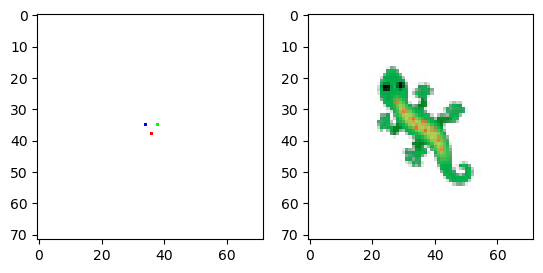

In [36]:
# Get seed to train on 
seed, pad_target = make_seed(target_img, radius=2)

batch (before/after):


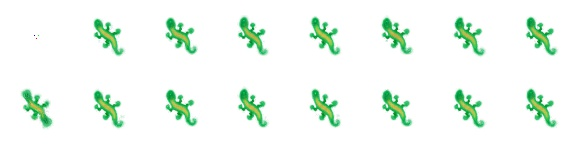

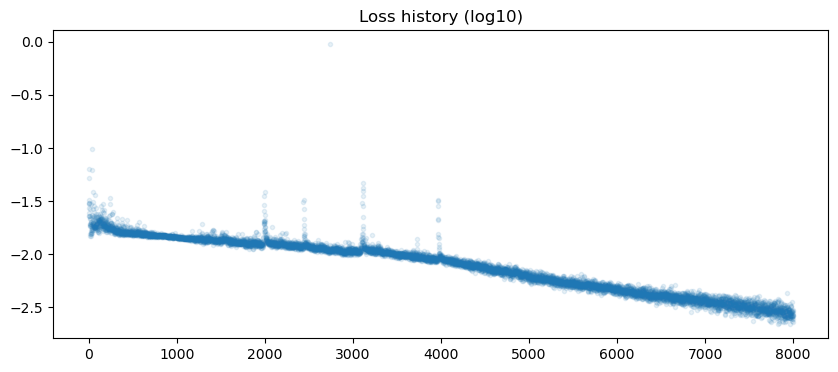

 step: 8001, log10(loss): -2.604
Elapsed time for training run on 8001 steps: 2073.471301317215
CPU times: user 34min 34s, sys: 14.8 s, total: 34min 49s
Wall time: 34min 36s


In [37]:
%%time



ca = CAModel(N=4,
             hidden_repr='regular',
             hidden_repr_size=64, # this is 16*4
             channel_n=CHANNEL_N,
             hidden_size=HIDDEN_SIZE
            ).to(device)

train = Train(ca, seed.to(device), pad_target.to(device))
loss_log = train.train(n_steps=8001)

filename = create_filename(N=4,
             hidden_repr='trivial',
             hidden_repr_size=48,
             channel_n=CHANNEL_N,
             hidden_size=HIDDEN_SIZE)
save_ca_model(ca, filename)
save_loss_log(loss_log, filename)

In [41]:
filename = create_filename(N=4,
             hidden_repr='trivial',
             hidden_repr_size=48,
             channel_n=CHANNEL_N,
             hidden_size=HIDDEN_SIZE)
save_ca_model(ca, filename)
save_loss_log(loss_log, filename)

Saved model C4_trivial-48_channeln-16_hiddensz-128 to disk
Saved array under C4_trivial-48_channeln-16_hiddensz-128 name to disk


CAModel(
  (gpool): GroupPooling([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}])
  (perceive): SequentialModule(
    (0): R2Conv([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_

In [26]:
def rotate(tensor, element):
    """Take a PyTorch tensor and apply an element transformation
    from the cyclic group C4, returning a PyTorch tensor again.
    """
    if len(tensor.shape) < 4:
        tensor = tensor.unsqueeze(0)
    n_channels = tensor.shape[-1] # extract the number of channels
    r2_act = gspaces.Rot2dOnR2(N=4)
    in_type = e2cnn.nn.FieldType(r2_act, n_channels*[r2_act.trivial_repr])
    geometric_tensor = e2cnn.nn.GeometricTensor(tensor.permute(0, -1, 1, 2), in_type)
    return geometric_tensor.transform(element).tensor.permute(0, 2, 3, 1)
rotated_seed = rotate(seed.cpu(), 1)
rotated_seed.shape
seed.shape

torch.Size([72, 72, 16])

In [13]:
ca = load_ca_model(CAModel, "test_model", N=4,
             hidden_repr='regular',
             hidden_repr_size=48,
             channel_n=CHANNEL_N,
             hidden_size=HIDDEN_SIZE, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 668.75it/s]


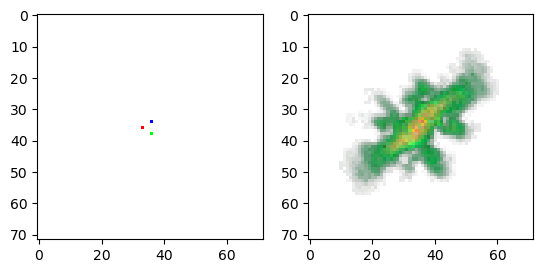

In [31]:
_ = simulate_model(ca, rotate(seed.unsqueeze(0), 3), 90, device=device)